In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import datetime
import matplotlib.dates as mdates

In [2]:
#contracts = ['F4', 'G4', 'H4', 'J4', 'K4', 'M4']
#contracts = ['N4', 'Q4', 'U4', 'V4', 'X4', 'Z4']
contracts = ['F3', 'G3', 'H3', 'J3', 'K3', 'M3']
data_dir = "/Users/bx/Documents/Futures_strategy"  
dfs = {}

for contract in contracts:
    file_name = f"CFE_VX_{contract}.csv"
    file_path = os.path.join(data_dir, file_name)
    # Assume CSV has a header row, adjust arguments as needed (e.g., parse_dates, index_col)
    df = pd.read_csv(file_path, parse_dates=['Trade Date'])  # Replace 'date' with your date column name
    dfs[contract] = df

print(dfs)

{'F3':     Trade Date       Futures   Open   High    Low  Close   Settle  Change  \
0   2022-04-25  F (Jan 2023)   0.00  26.00  28.50   0.00  27.2500  0.0000   
1   2022-04-26  F (Jan 2023)   0.00  27.40  28.25   0.00  27.8000  0.5500   
2   2022-04-27  F (Jan 2023)   0.00  27.25  27.95   0.00  27.7500 -0.0500   
3   2022-04-28  F (Jan 2023)  27.90  27.90  27.20  27.51  27.3500 -0.4000   
4   2022-04-29  F (Jan 2023)   0.00  27.40  27.65   0.00  27.8250  0.4750   
..         ...           ...    ...    ...    ...    ...      ...     ...   
180 2023-01-11  F (Jan 2023)  21.15  21.45  21.00  21.25  21.2004  0.1055   
181 2023-01-12  F (Jan 2023)  21.25  21.62  19.79  19.95  19.8200 -1.3804   
182 2023-01-13  F (Jan 2023)  19.90  20.20  19.13  19.35  19.4988 -0.3212   
183 2023-01-17  F (Jan 2023)  19.45  20.10  19.25  19.60  19.3155 -0.1833   
184 2023-01-18  F (Jan 2023)  19.55  19.70  18.95  19.09  19.0900 -0.2255   

     Total Volume  EFP  Open Interest  
0               0    0      

In [4]:
# 1. Find common dates
dates_sets = [set(df['Trade Date']) for df in dfs.values()]
common_dates = sorted(set.intersection(*dates_sets))


# 2. Filter each DataFrame to only use common dates:
for contract in contracts:
    dfs[contract] = dfs[contract][dfs[contract]['Trade Date'].isin(common_dates)]


# 3. Rename 'Settle' to a unique price column name for each contract
for contract in contracts:
    dfs[contract].rename(columns={'Settle': f'price_{contract}'}, inplace=True)


# 4. Create a merged DataFrame on 'Trade Date'
merged_df = pd.DataFrame({'Trade Date': common_dates})
for contract in contracts:
    merged_df = merged_df.merge(
        dfs[contract][['Trade Date', f'price_{contract}']],
        on='Trade Date',
        how='left'
    )

merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
print(merged_df.head())

  Trade Date  price_F3  price_G3  price_H3  price_J3  price_K3  price_M3
0 2022-09-26   30.2518   30.0012   29.9538   30.1029    29.925    29.600
1 2022-09-27   30.4467   30.1661   30.0973   30.1984    29.925    29.725
2 2022-09-28   29.8700   29.6711   29.6316   29.7250    29.525    29.325
3 2022-09-29   30.3998   30.1000   30.0000   30.0925    29.850    29.575
4 2022-09-30   30.7021   30.3100   30.1800   30.2487    30.000    29.700


plotting evolution of term structure


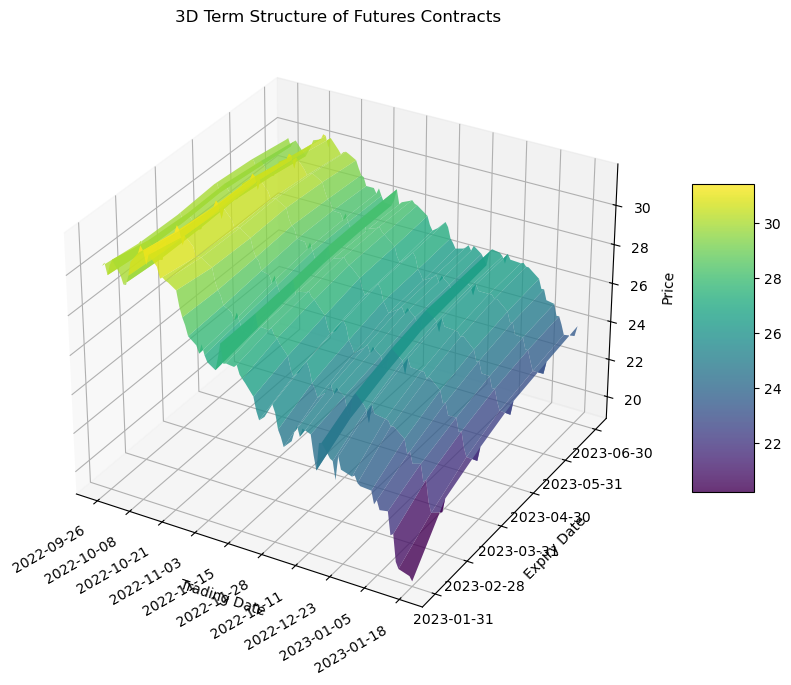

In [5]:

expiry_mapping = {
    'F3': datetime.datetime(2023, 1, 31),
    'G3': datetime.datetime(2023, 2, 28),
    'H3': datetime.datetime(2023, 3, 31),
    'J3': datetime.datetime(2023, 4, 30),
    'K3': datetime.datetime(2023, 5, 31),
    'M3': datetime.datetime(2023, 6, 30)
}

# Convert the trading date in the merged DataFrame to datetime (if not already)
merged_df['Trade Date'] = pd.to_datetime(merged_df['Trade Date'])

# Convert Trade Date to ordinal numbers for the X-axis
merged_df['date_ord'] = merged_df['Trade Date'].apply(lambda d: d.toordinal())

# Create an array of expiry ordinals corresponding to each contract (for the Y-axis)
expiry_ord = np.array([expiry_mapping[contract].toordinal() for contract in contracts])

# Create the grid for the surface plot:
# X: Trading dates (ordinals)
# Y: Expiry dates (ordinals)
# Z: Prices

# Convert the 'Trade Date' column to a numpy array of ordinals:
X_vals = merged_df['date_ord'].values  # shape (n_dates,)

# Create meshgrid for X and Y:
X_grid, Y_grid = np.meshgrid(X_vals, expiry_ord)

# Create Z_grid: each row is the price series for a contract
Z_grid = np.empty_like(X_grid, dtype=float)
for i, contract in enumerate(contracts):
    colname = f'price_{contract}'
    Z_grid[i, :] = merged_df[colname].values

# Now, plot the 3D surface:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', edgecolor='none', alpha=0.8)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Format the X-axis ticks: convert ordinals back to dates
# We'll choose a reasonable number of ticks:
n_ticks = 10
tick_positions = np.linspace(merged_df['date_ord'].min(), merged_df['date_ord'].max(), n_ticks)
tick_labels = [datetime.datetime.fromordinal(int(pos)).strftime('%Y-%m-%d') for pos in tick_positions]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=30, ha='right')

# Format the Y-axis ticks: convert expiry ordinals back to dates
expiry_dates = [datetime.datetime.fromordinal(int(o)).strftime('%Y-%m-%d') for o in expiry_ord]
ax.set_yticks(expiry_ord)
ax.set_yticklabels(expiry_dates)

ax.set_xlabel('Trading Date')
ax.set_ylabel('Expiry Date')
ax.set_zlabel('Price')
ax.set_title('3D Term Structure of Futures Contracts')

plt.show()


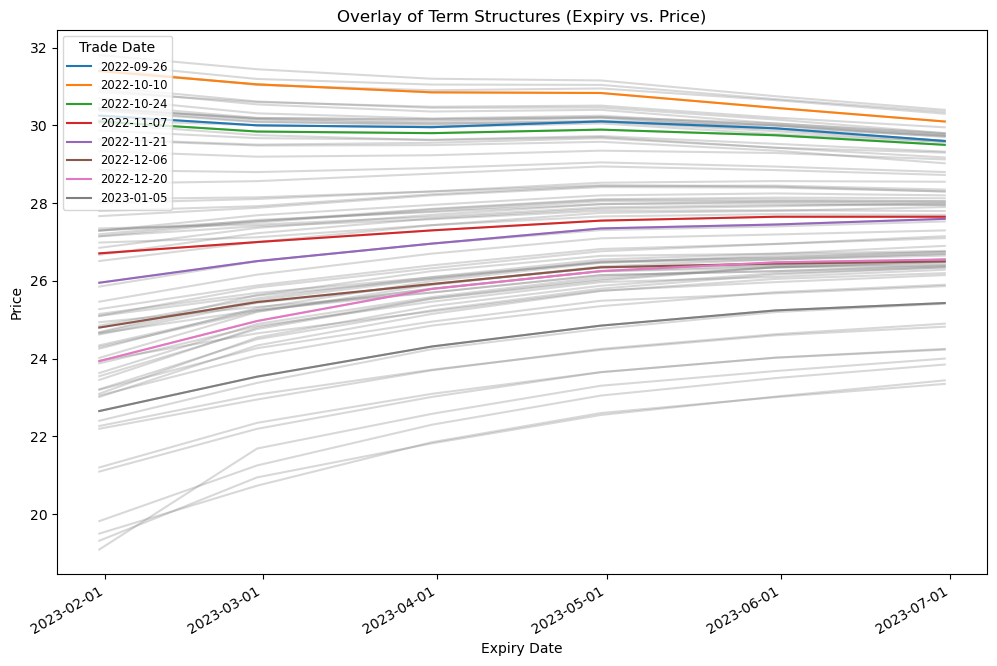

In [6]:
# Create a list of expiry dates in order (x-axis)
expiry_dates = [expiry_mapping[contract] for contract in contracts]

plt.figure(figsize=(12, 8))

# Option 1: Plot every term structure (one line per trading date)
for _, row in merged_df.iterrows():
    # Extract the price for each contract
    prices = [row[f'price_{contract}'] for contract in contracts]
    # Plot term structure for this trading date
    plt.plot(expiry_dates, prices, color='gray', alpha=0.3)

# Option 2: Optionally highlight a subset of term structures by, say, color-coding by time.
# For example, you might color-code every 10th term structure to see the evolution more clearly:
for i, (_, row) in enumerate(merged_df.iterrows()):
    if i % 10 == 0:
        prices = [row[f'price_{contract}'] for contract in contracts]
        plt.plot(expiry_dates, prices, label=row['Trade Date'].strftime('%Y-%m-%d'))

# Format the x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

plt.xlabel('Expiry Date')
plt.ylabel('Price')
plt.title('Overlay of Term Structures (Expiry vs. Price)')
plt.legend(title='Trade Date', loc='upper left', fontsize='small')
plt.show()

   Trade Date  price_F3  price_G3  price_H3  price_J3  price_K3  price_M3  \
0  2022-09-26   30.2518   30.0012   29.9538   30.1029   29.9250   29.6000   
1  2022-09-27   30.4467   30.1661   30.0973   30.1984   29.9250   29.7250   
2  2022-09-28   29.8700   29.6711   29.6316   29.7250   29.5250   29.3250   
3  2022-09-29   30.3998   30.1000   30.0000   30.0925   29.8500   29.5750   
4  2022-09-30   30.7021   30.3100   30.1800   30.2487   30.0000   29.7000   
..        ...       ...       ...       ...       ...       ...       ...   
74 2023-01-11   21.2004   22.3485   23.0948   23.6512   24.0259   24.2500   
75 2023-01-12   19.8200   21.2520   22.2997   23.0500   23.5000   23.8475   
76 2023-01-13   19.4988   20.7317   21.8500   22.6009   23.0089   23.3493   
77 2023-01-17   19.3155   20.9452   21.8203   22.5505   23.0235   23.4405   
78 2023-01-18   19.0900   21.6874   22.5799   23.3032   23.6812   24.0011   

    date_ord  
0     738424  
1     738425  
2     738426  
3     738427  


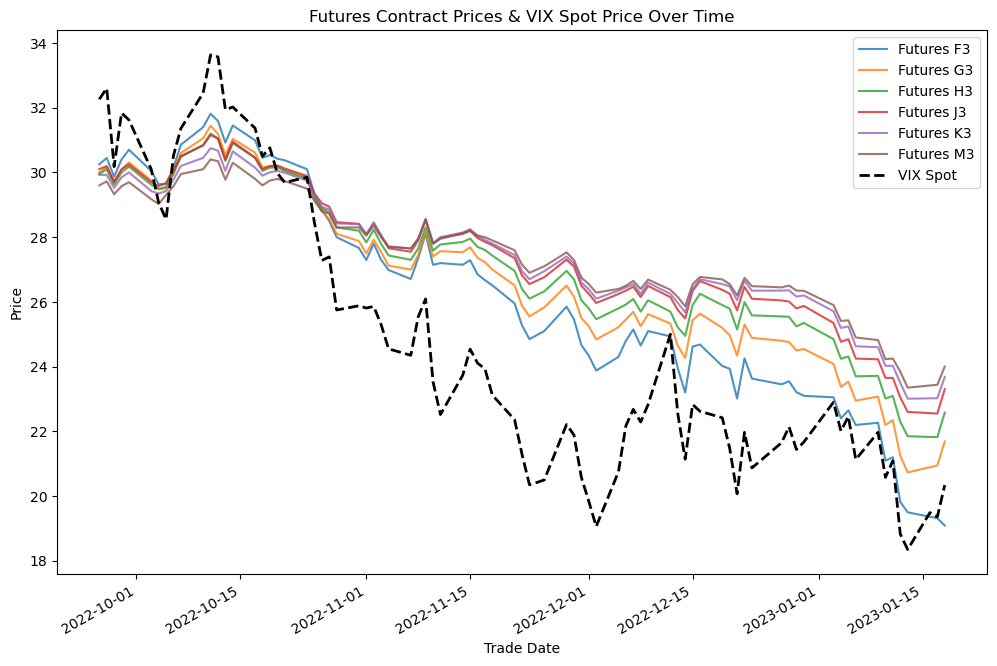

In [81]:
vix_data = pd.read_csv('/Users/bx/Documents/Futures_strategy/VIX_History.csv', parse_dates=['DATE'])


# Assume merged_df exists with a 'Trade Date' column
start_date = merged_df['Trade Date'].min()
end_date = merged_df['Trade Date'].max()

vix_data = vix_data[(vix_data['DATE'] >= start_date) & (vix_data['DATE'] <= end_date)]

# -----------------------------
# 3. Plot Futures Prices and VIX Spot Price
# -----------------------------
plt.figure(figsize=(12, 8))
# Plot each futures contract price over time from merged_df
for contract in contracts:
    plt.plot(merged_df['Trade Date'], merged_df[f'price_{contract}'], 
             label=f'Futures {contract}', alpha=0.8)

# Overlay the VIX spot price using the 'Adj Close' column (adjust if your column is named differently)
plt.plot(vix_data['DATE'], vix_data['CLOSE'], 
         label='VIX Spot', color='black', linewidth=2, linestyle='--')

# Format the x-axis to display dates properly:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

# Add labels and title
plt.xlabel("Trade Date")
plt.ylabel("Price")
plt.title("Futures Contract Prices & VIX Spot Price Over Time")
plt.legend()
plt.show()

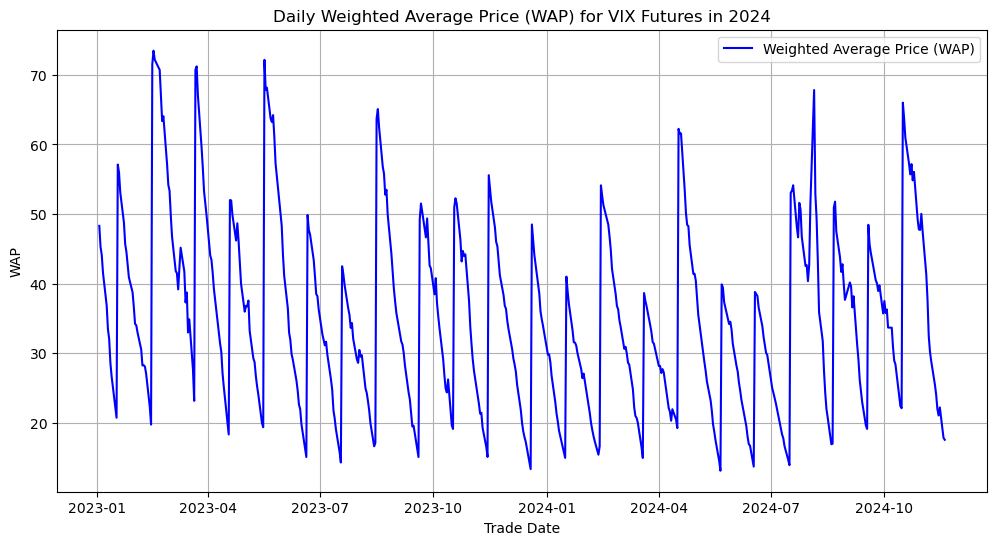

In [7]:
#strat_contracts = ['F4', 'G4', 'H4', 'J4', 'K4', 'M4', 'N4', 'Q4', 'U4', 'V4', 'X4', 'Z4']
#strat_contracts = ['F3', 'G3', 'H3', 'J3', 'K3', 'M3', 'N3', 'Q3', 'U3', 'V3', 'X3', 'Z3']
strat_contracts = ['F2', 'G2', 'H2', 'J2', 'K2', 'M2', 'N2', 'Q2', 'U2', 'V2', 'X2', 'Z2', 'F3', 'G3', 'H3', 'J3', 'K3', 'M3', 'N3', 'Q3', 'U3', 'V3', 'X3', 'Z3', 'F4', 'G4', 'H4', 'J4', 'K4', 'M4', 'N4', 'Q4', 'U4', 'V4', 'X4', 'Z4']
# Path to folder containing your CSV files.
data_dir = "/Users/bx/Documents/Futures_strategy"    # Adjust this to your CSV location
start_date = '2023-01-01'
end_date = '2024-12-31'
# Dictionary to hold DataFrames and settlement dates.
dfs = {}
settlement_dates = {}

for code in strat_contracts:
    filename = f"CFE_VX_{code}.csv"
    filepath = os.path.join(data_dir, filename)
    # Read CSV, parsing 'Trade Date' as datetime.
    df_code = pd.read_csv(filepath, parse_dates=['Trade Date'])
    # Rename the 'Settle' column to a unique column for that contract.
    df_code = df_code.rename(columns={'Settle': f'price_{code}'})
    # Keep only the relevant columns.
    df_code = df_code[['Trade Date', f'price_{code}']]
    dfs[code] = df_code
    # The settlement date for the contract is assumed to be the last available date.
    settlement_dates[code] = df_code['Trade Date'].max().date()
    #print(f"Contract {code} settlement date (from CSV): {settlement_dates[code]}")

# Merge all DataFrames on 'Trade Date'
merged_df = None
for code in strat_contracts:
    if merged_df is None:
        merged_df = dfs[code]
    else:
        merged_df = pd.merge(merged_df, dfs[code], on='Trade Date', how='outer')

# Sort by Trade Date and filter for 2024.
merged_df = merged_df.sort_values('Trade Date').reset_index(drop=True)
merged_df = merged_df[(merged_df['Trade Date'] >= start_date) & (merged_df['Trade Date'] <= end_date)]

# -------------------------------
# 2. Calculate Daily WAP for 2024 Using the CSV Settlement Dates
# -------------------------------

# Create a daily date range for 2024.
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

results = []
# Loop over each day in 2024.
for current_date in date_range:
    current_date_obj = current_date.date()
    
    # Determine active contracts: those whose settlement date is after the current date.
    active_contracts = []
    for code, settle in settlement_dates.items():
        if current_date_obj < settle:
            active_contracts.append((settle, code))
    
    # Need at least two active contracts for front and back.
    if len(active_contracts) < 2:
        continue
    
    # Sort active contracts by settlement date (earliest first).
    active_contracts.sort(key=lambda x: x[0])
    front_settle, front_code = active_contracts[0]
    back_settle, back_code = active_contracts[1]
    
    # Compute days to expiry.
    D_FM = (front_settle - current_date_obj).days
    D_BM = (back_settle - current_date_obj).days
    
    # Get the price data for the current date from merged_df.
    row = merged_df[merged_df['Trade Date'] == current_date]
    if row.empty:
        continue  # No price data for this date.
    row = row.iloc[0]
    
    try:
        P_FM = row[f'price_{front_code}']
        P_BM = row[f'price_{back_code}']
    except KeyError:
        # If any required price is missing, skip this date.
        continue
    
    # Avoid division by zero (should not occur if D_BM > D_FM).
    if D_BM - D_FM == 0:
        continue
    
    # Calculate the Weighted Average Price (WAP).
    WAP = (D_BM / (D_BM - D_FM)) * P_FM + (D_FM / (D_BM - D_FM)) * P_BM
    
    results.append({
        'Trade Date': current_date,
        'Front Contract': front_code,
        'Back Contract': back_code,
        'P_FM': P_FM,
        'P_BM': P_BM,
        'D_FM': D_FM,
        'D_BM': D_BM,
        'WAP': WAP
    })

wap_df = pd.DataFrame(results)
wap_df.sort_values('Trade Date', inplace=True)

# -------------------------------
# 3. Plot the WAP over time for 2024
# -------------------------------

plt.figure(figsize=(12, 6))
plt.plot(wap_df['Trade Date'], wap_df['WAP'], label='Weighted Average Price (WAP)', color='blue')
plt.xlabel('Trade Date')
plt.ylabel('WAP')
plt.title('Daily Weighted Average Price (WAP) for VIX Futures in 2024')
plt.legend()
plt.grid(True)
plt.show()

     Trade Date  CLOSE
8317 2023-01-03  22.90
8318 2023-01-04  22.01
8319 2023-01-05  22.46
8320 2023-01-06  21.13
8321 2023-01-09  21.97
0.9603113535772725


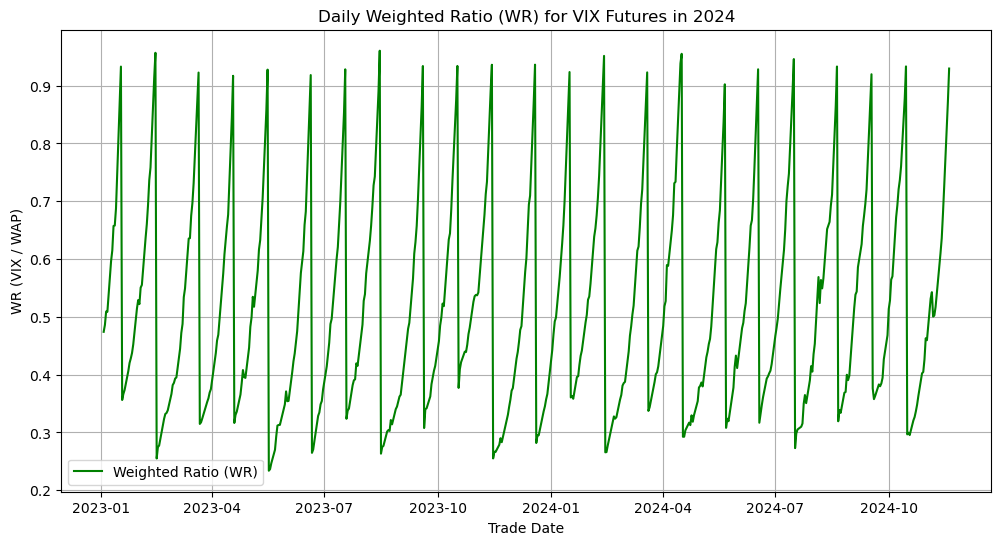

In [8]:

vix_data = pd.read_csv('/Users/bx/Documents/Futures_strategy/VIX_History.csv', parse_dates=['DATE'])
vix_data = vix_data.rename(columns={'DATE': 'Trade Date'})
# Ensure we only keep the necessary columns (assuming "VIX" is the column with the VIX spot price).
vix_data = vix_data[['Trade Date', 'CLOSE']]


# Filter VIX data for 2024.
start_date = '2023-01-01'
end_date = '2024-12-31'
vix_data = vix_data[(vix_data['Trade Date'] >= start_date) & (vix_data['Trade Date'] <= end_date)]

print(vix_data.head())
# Merge the VIX data with the WAP data (wap_df) on 'Trade Date'.
# (wap_df is assumed to have been created previously with columns: 'Trade Date' and 'WAP')
wap_vix_df = pd.merge(wap_df, vix_data, on='Trade Date', how='inner')

# Calculate the Weighted Ratio (WR)
wap_vix_df['WR'] = wap_vix_df['CLOSE'] / wap_vix_df['WAP']

print(wap_vix_df['WR'].max())
# -------------------------------
# Plot WR over time for 2024
# -------------------------------
plt.figure(figsize=(12, 6))
plt.plot(wap_vix_df['Trade Date'], wap_vix_df['WR'], label='Weighted Ratio (WR)', color='green')
plt.xlabel('Trade Date')
plt.ylabel('WR (VIX / WAP)')
plt.title('Daily Weighted Ratio (WR) for VIX Futures in 2024')
plt.legend()
plt.grid(True)
plt.show()

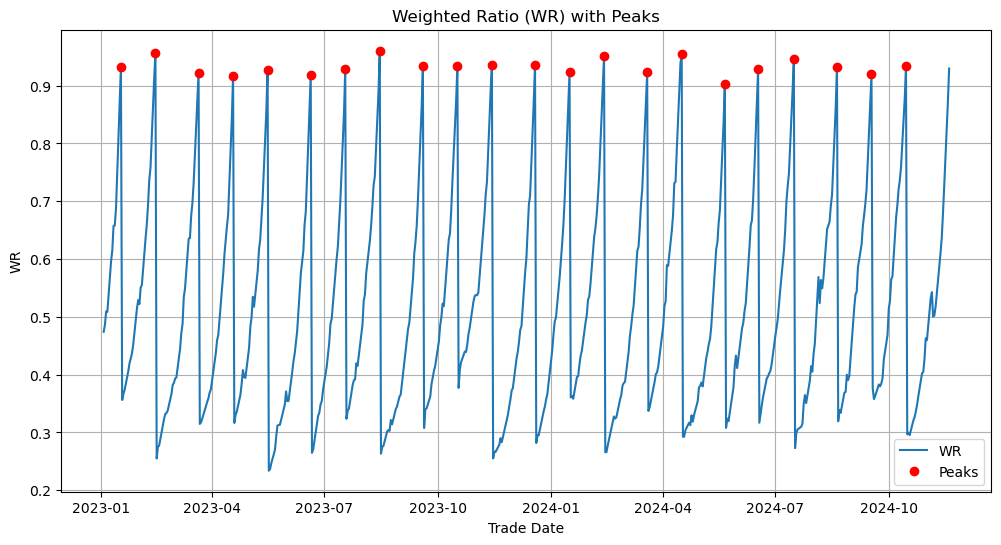

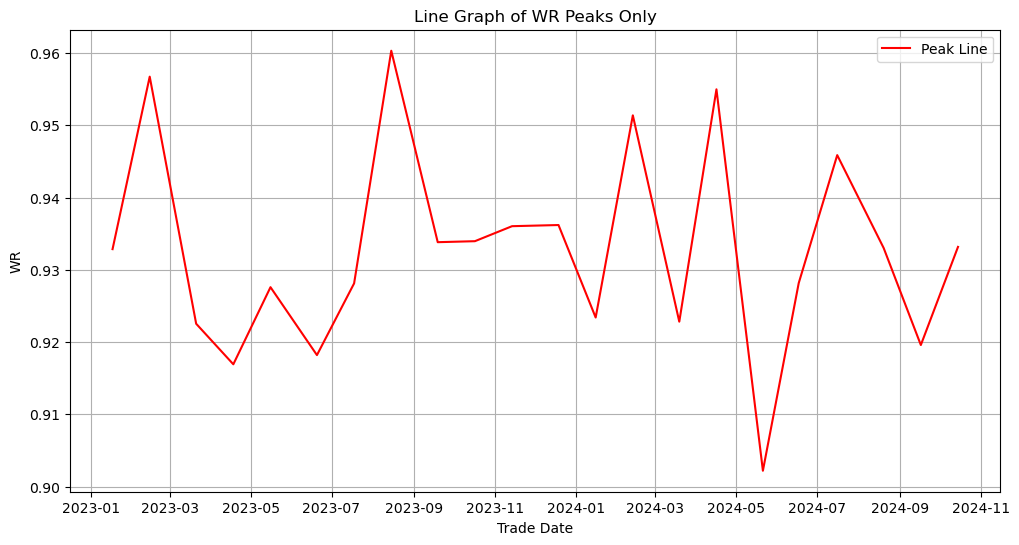

In [11]:
from scipy.signal import find_peaks

# Find peaks in the WR column.
# You can adjust parameters like 'height' or 'distance' to refine the detection.
peaks, properties = find_peaks(wap_vix_df['WR'], height=0.8)

# Extract peak dates and peak values
peak_dates = wap_vix_df.loc[peaks, 'Trade Date']
peak_values = wap_vix_df.loc[peaks, 'WR']

# Plot the full WR series and overlay the peaks
plt.figure(figsize=(12,6))
plt.plot(wap_vix_df['Trade Date'], wap_vix_df['WR'], label="WR")
plt.plot(peak_dates, peak_values, 'ro', label="Peaks")
plt.xlabel("Trade Date")
plt.ylabel("WR")
plt.title("Weighted Ratio (WR) with Peaks")
plt.legend()
plt.grid(True)
plt.show()

# Optionally, if you only want a line graph connecting the peaks:
plt.figure(figsize=(12,6))
plt.plot(peak_dates, peak_values, 'r-', label="Peak Line")
plt.xlabel("Trade Date")
plt.ylabel("WR")
plt.title("Line Graph of WR Peaks Only")
plt.legend()
plt.grid(True)
plt.show()

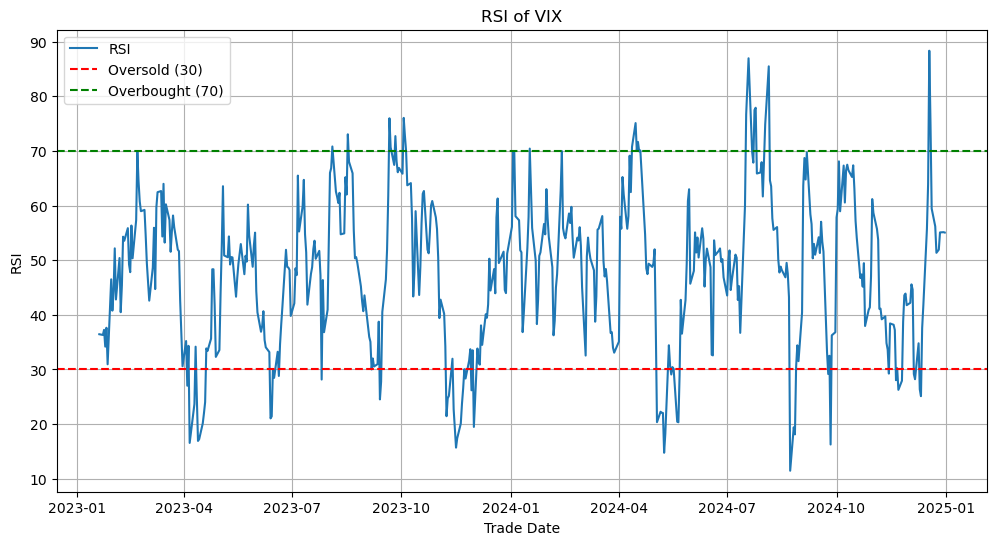

In [12]:
def compute_RSI(series, window=14):
    """
    Compute the Relative Strength Index (RSI) for a given pandas Series.

    Parameters:
      series (pd.Series): The price series.
      window (int): The lookback period for RSI calculation, default is 14.

    Returns:
      pd.Series: RSI values.
    """
    # Calculate price differences
    delta = series.diff()

    # Separate positive and negative gains
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the rolling average of gains and losses
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # Compute the Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Compute RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Example usage:
# Assuming 'vix_data' DataFrame has a column 'CLOSE' representing the VIX price:
vix_data['RSI'] = compute_RSI(vix_data['CLOSE'], window=14)

# Plot RSI over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(vix_data['Trade Date'], vix_data['RSI'], label='RSI')
plt.axhline(30, color='red', linestyle='--', label='Oversold (30)')
plt.axhline(70, color='green', linestyle='--', label='Overbought (70)')
plt.xlabel('Trade Date')
plt.ylabel('RSI')
plt.title('RSI of VIX')
plt.legend()
plt.grid(True)
plt.show()


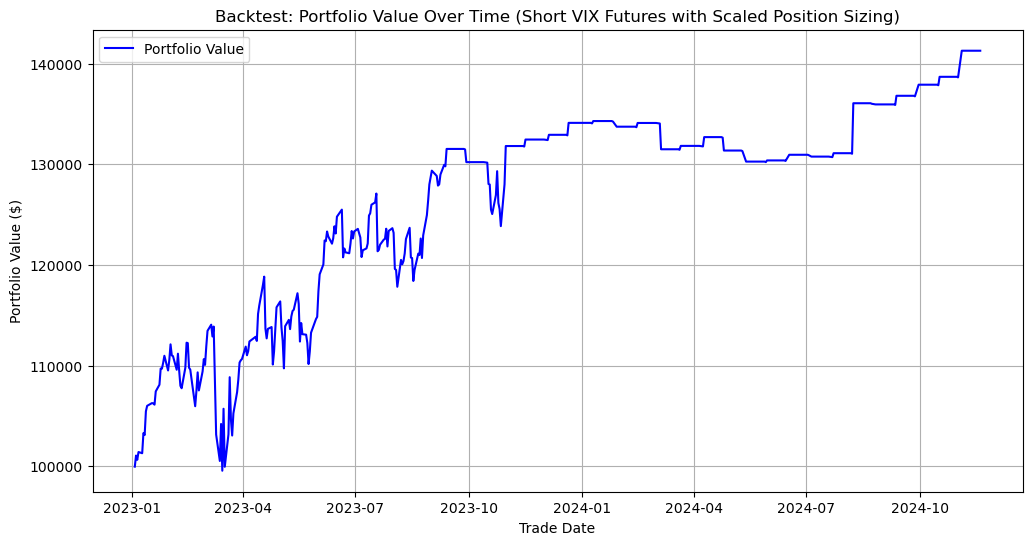

Annualized Sharpe Ratio: 1.1288137249821886
Initial Portfolio: $100,000.00
Final Portfolio:   $141,272.65
Total Return:      41.27%


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Initial settings
initial_portfolio = 100000
portfolio = initial_portfolio
contract_multiplier = 100  
transaction_cost_rate = 0.001  

# Entry and exit thresholds
entry_threshold = 0.90  
exit_threshold = 0.93  
profit_lock_threshold = 1.3  
waiting_period = 10  # Number of days to wait after a profit lock

# Position sizing parameter (fraction of portfolio to deploy)
desired_exposure = 0.40  # 40% of portfolio per trade

# State variables
position = 0  # 0 means no position; negative means short position (number of contracts)
entry_price = None
prev_price = None
portfolio_history = []
trade_signals = []
wait_counter = 0

# Ensure wap_vix_df is sorted by Trade Date.
wap_vix_df = wap_vix_df.sort_values('Trade Date').reset_index(drop=True)

for i, row in wap_vix_df.iterrows():
    current_date = row['Trade Date']
    WR = row['WR']
    P_FM = row['P_FM']  # Trade price

    # If in waiting period, skip trading
    if wait_counter > 0:
        wait_counter -= 1
        portfolio_history.append({'Trade Date': current_date, 'Portfolio': portfolio, 'WR': WR})
        continue

    # If in position, mark-to-market P&L for all contracts held
    if position != 0:
        if prev_price is not None:
            # For short positions, profit when price falls.
            daily_pnl = (prev_price - P_FM) * abs(position) * contract_multiplier
            portfolio += daily_pnl
        prev_price = P_FM

    # Check if we should exit due to profit lock
    if position != 0 and (portfolio / initial_portfolio) >= profit_lock_threshold:
        trade_signals.append((current_date, 'Profit Lock Exit', P_FM, WR, position))
        position = 0
        entry_price = None
        prev_price = None
        wait_counter = waiting_period
    
    # Trading logic
    if position == 0 and wait_counter == 0:
        if WR < entry_threshold:
            # Determine the number of contracts based on desired exposure.
            num_contracts = max(1, round((desired_exposure * portfolio) / (P_FM * contract_multiplier)))
            # For a short position, we use negative number.
            position = -num_contracts  
            entry_price = P_FM
            prev_price = P_FM
            cost = P_FM * contract_multiplier * num_contracts * transaction_cost_rate
            portfolio -= cost
            trade_signals.append((current_date, 'Enter Short', P_FM, WR, position))
    elif position < 0:
        if WR > exit_threshold:
            num_contracts = abs(position)
            cost = P_FM * contract_multiplier * num_contracts * transaction_cost_rate
            portfolio -= cost
            trade_signals.append((current_date, 'Exit Short', P_FM, WR, position))
            position = 0
            entry_price = None
            prev_price = None
    
    # Record portfolio history
    portfolio_history.append({'Trade Date': current_date, 'Portfolio': portfolio, 'WR': WR})

portfolio_df = pd.DataFrame(portfolio_history)

plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['Trade Date'], portfolio_df['Portfolio'], label='Portfolio Value', color='blue')
plt.xlabel('Trade Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Backtest: Portfolio Value Over Time (Short VIX Futures with Scaled Position Sizing)')
plt.legend()
plt.grid(True)
plt.show()

# Print summary statistics
portfolio_df['Return'] = portfolio_df['Portfolio'].pct_change()

# Remove the initial NaN value from the pct_change calculation
daily_returns = portfolio_df['Return'].dropna()

# Compute the mean and standard deviation of daily returns.
mean_daily_return = daily_returns.mean()
std_daily_return = daily_returns.std()

# Annualize the Sharpe Ratio assuming 252 trading days per year.
# (Here, risk-free rate is assumed to be 0.)
annual_sharpe = (mean_daily_return / std_daily_return) * np.sqrt(252)

print("Annualized Sharpe Ratio:", annual_sharpe)
final_value = portfolio_df['Portfolio'].iloc[-1]
print(f"Initial Portfolio: ${initial_portfolio:,.2f}")
print(f"Final Portfolio:   ${final_value:,.2f}")
print(f"Total Return:      {(final_value/initial_portfolio - 1)*100:.2f}%")